In [28]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tensorflow as tf
import torchvision
import torchvision.utils as vutils
import torch.utils.data as data

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [30]:
# Root directory for dataset
dataroot = "C:/Users/Álvaro Fernando/Desktop/IA proyecto/img/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 60

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


100000
1563
cuda:0


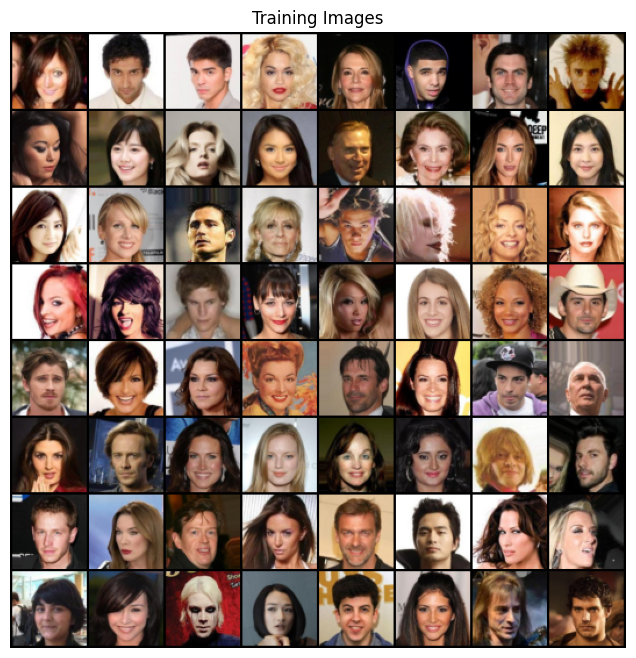

In [31]:

# Create the dataset
full_dataset = dset.ImageFolder(root=dataroot,
                                transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ]))

# specify number of images to use
num_images = 100000

# create a subset of the full dataset with the specified number of images
subset_indices = list(range(num_images))
subset_dataset = data.Subset(full_dataset, subset_indices)

print(len(subset_dataset))
# create dataloader
dataloader = torch.utils.data.DataLoader(subset_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print(len(dataloader))
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
torch.cuda.is_available()

True

In [32]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [33]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [34]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [35]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [36]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [37]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [38]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
output_dir = "C:/Users/Álvaro Fernando/Desktop/IA proyecto/result_GAN/"

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            torchvision.utils.save_image(fake, f"{output_dir}/{epoch}_{i}.png", normalize=True)
        iters += 1

Starting Training Loop...
[0/60][0/1563]	Loss_D: 1.9708	Loss_G: 5.7277	D(x): 0.6312	D(G(z)): 0.6919 / 0.0045
[0/60][50/1563]	Loss_D: 0.2732	Loss_G: 34.8176	D(x): 0.8881	D(G(z)): 0.0000 / 0.0000
[0/60][100/1563]	Loss_D: 0.0059	Loss_G: 41.5781	D(x): 0.9945	D(G(z)): 0.0000 / 0.0000
[0/60][150/1563]	Loss_D: 0.0016	Loss_G: 40.5562	D(x): 0.9985	D(G(z)): 0.0000 / 0.0000
[0/60][200/1563]	Loss_D: 0.0001	Loss_G: 40.3275	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/60][250/1563]	Loss_D: 0.0002	Loss_G: 39.9577	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[0/60][300/1563]	Loss_D: 0.0000	Loss_G: 39.8718	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/60][350/1563]	Loss_D: 0.0000	Loss_G: 39.7065	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/60][400/1563]	Loss_D: 0.0001	Loss_G: 39.0753	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/60][450/1563]	Loss_D: 0.0004	Loss_G: 36.9338	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/60][500/1563]	Loss_D: 1.0664	Loss_G: 8.3613	D(x): 0.9497	D(G(z)): 0.4603 / 0.0014
[0/60][550/1563]	Loss_D: 1.8076	L

[3/60][0/1563]	Loss_D: 0.4022	Loss_G: 3.1517	D(x): 0.7706	D(G(z)): 0.0834 / 0.0642
[3/60][50/1563]	Loss_D: 0.8861	Loss_G: 4.5154	D(x): 0.9443	D(G(z)): 0.5002 / 0.0169
[3/60][100/1563]	Loss_D: 0.8229	Loss_G: 1.2539	D(x): 0.5918	D(G(z)): 0.1756 / 0.3357
[3/60][150/1563]	Loss_D: 0.6924	Loss_G: 3.0320	D(x): 0.8214	D(G(z)): 0.3346 / 0.0631
[3/60][200/1563]	Loss_D: 0.8553	Loss_G: 1.4267	D(x): 0.5702	D(G(z)): 0.1318 / 0.3023
[3/60][250/1563]	Loss_D: 0.5358	Loss_G: 2.4139	D(x): 0.8525	D(G(z)): 0.2732 / 0.1222
[3/60][300/1563]	Loss_D: 0.7394	Loss_G: 2.6609	D(x): 0.7773	D(G(z)): 0.3122 / 0.0978
[3/60][350/1563]	Loss_D: 0.5210	Loss_G: 1.4509	D(x): 0.7033	D(G(z)): 0.0901 / 0.2713
[3/60][400/1563]	Loss_D: 0.6160	Loss_G: 2.2462	D(x): 0.6386	D(G(z)): 0.0910 / 0.1456
[3/60][450/1563]	Loss_D: 0.2442	Loss_G: 3.3665	D(x): 0.9251	D(G(z)): 0.1414 / 0.0462
[3/60][500/1563]	Loss_D: 0.6710	Loss_G: 1.5627	D(x): 0.5944	D(G(z)): 0.0464 / 0.2439
[3/60][550/1563]	Loss_D: 0.4844	Loss_G: 3.4155	D(x): 0.7409	D(G(z)):

[6/60][50/1563]	Loss_D: 0.6731	Loss_G: 1.6458	D(x): 0.6538	D(G(z)): 0.1465 / 0.2338
[6/60][100/1563]	Loss_D: 0.3364	Loss_G: 3.2689	D(x): 0.9036	D(G(z)): 0.1882 / 0.0493
[6/60][150/1563]	Loss_D: 0.4790	Loss_G: 2.8975	D(x): 0.8244	D(G(z)): 0.2121 / 0.0760
[6/60][200/1563]	Loss_D: 0.3352	Loss_G: 3.7717	D(x): 0.9122	D(G(z)): 0.1992 / 0.0350
[6/60][250/1563]	Loss_D: 0.7657	Loss_G: 3.9557	D(x): 0.9301	D(G(z)): 0.4262 / 0.0296
[6/60][300/1563]	Loss_D: 0.9048	Loss_G: 0.8549	D(x): 0.5028	D(G(z)): 0.0450 / 0.4966
[6/60][350/1563]	Loss_D: 0.3873	Loss_G: 3.3975	D(x): 0.8901	D(G(z)): 0.1904 / 0.0498
[6/60][400/1563]	Loss_D: 0.5943	Loss_G: 1.8207	D(x): 0.6330	D(G(z)): 0.0507 / 0.2177
[6/60][450/1563]	Loss_D: 0.4144	Loss_G: 2.4490	D(x): 0.8143	D(G(z)): 0.1643 / 0.1022
[6/60][500/1563]	Loss_D: 0.2027	Loss_G: 3.9351	D(x): 0.8791	D(G(z)): 0.0589 / 0.0363
[6/60][550/1563]	Loss_D: 0.3887	Loss_G: 3.1895	D(x): 0.8425	D(G(z)): 0.1731 / 0.0559
[6/60][600/1563]	Loss_D: 0.4586	Loss_G: 3.1344	D(x): 0.8759	D(G(z)

[9/60][100/1563]	Loss_D: 0.6342	Loss_G: 1.5498	D(x): 0.6250	D(G(z)): 0.0776 / 0.2791
[9/60][150/1563]	Loss_D: 0.3521	Loss_G: 3.1613	D(x): 0.8734	D(G(z)): 0.1706 / 0.0586
[9/60][200/1563]	Loss_D: 0.5640	Loss_G: 3.8395	D(x): 0.8999	D(G(z)): 0.3348 / 0.0302
[9/60][250/1563]	Loss_D: 0.2000	Loss_G: 4.2153	D(x): 0.9375	D(G(z)): 0.1196 / 0.0218
[9/60][300/1563]	Loss_D: 0.5470	Loss_G: 2.6268	D(x): 0.9167	D(G(z)): 0.3239 / 0.0989
[9/60][350/1563]	Loss_D: 0.5920	Loss_G: 1.8282	D(x): 0.6469	D(G(z)): 0.0875 / 0.2162
[9/60][400/1563]	Loss_D: 0.5868	Loss_G: 1.7578	D(x): 0.7107	D(G(z)): 0.1584 / 0.2067
[9/60][450/1563]	Loss_D: 0.4674	Loss_G: 4.1958	D(x): 0.9322	D(G(z)): 0.2836 / 0.0210
[9/60][500/1563]	Loss_D: 0.5047	Loss_G: 2.4085	D(x): 0.7442	D(G(z)): 0.1394 / 0.1385
[9/60][550/1563]	Loss_D: 0.3275	Loss_G: 2.6939	D(x): 0.8576	D(G(z)): 0.1393 / 0.0846
[9/60][600/1563]	Loss_D: 0.6633	Loss_G: 5.6824	D(x): 0.9698	D(G(z)): 0.4156 / 0.0072
[9/60][650/1563]	Loss_D: 0.4972	Loss_G: 4.0093	D(x): 0.9178	D(G(z

[12/60][100/1563]	Loss_D: 0.3933	Loss_G: 3.4742	D(x): 0.8268	D(G(z)): 0.1520 / 0.0485
[12/60][150/1563]	Loss_D: 0.4743	Loss_G: 2.4638	D(x): 0.8024	D(G(z)): 0.1746 / 0.1175
[12/60][200/1563]	Loss_D: 2.2171	Loss_G: 0.1220	D(x): 0.1817	D(G(z)): 0.0725 / 0.8967
[12/60][250/1563]	Loss_D: 0.3688	Loss_G: 2.1462	D(x): 0.7782	D(G(z)): 0.0809 / 0.1693
[12/60][300/1563]	Loss_D: 0.2117	Loss_G: 3.5362	D(x): 0.9481	D(G(z)): 0.1387 / 0.0386
[12/60][350/1563]	Loss_D: 0.3415	Loss_G: 2.0796	D(x): 0.7650	D(G(z)): 0.0384 / 0.1659
[12/60][400/1563]	Loss_D: 0.3060	Loss_G: 3.7854	D(x): 0.8830	D(G(z)): 0.1383 / 0.0379
[12/60][450/1563]	Loss_D: 0.2814	Loss_G: 2.9506	D(x): 0.8549	D(G(z)): 0.0878 / 0.0841
[12/60][500/1563]	Loss_D: 0.2209	Loss_G: 4.1529	D(x): 0.9387	D(G(z)): 0.1300 / 0.0221
[12/60][550/1563]	Loss_D: 0.8971	Loss_G: 0.3612	D(x): 0.5151	D(G(z)): 0.0595 / 0.7358
[12/60][600/1563]	Loss_D: 0.1954	Loss_G: 3.6953	D(x): 0.9572	D(G(z)): 0.1202 / 0.0365
[12/60][650/1563]	Loss_D: 0.3719	Loss_G: 3.8066	D(x): 

[15/60][50/1563]	Loss_D: 0.1184	Loss_G: 4.2241	D(x): 0.9664	D(G(z)): 0.0758 / 0.0247
[15/60][100/1563]	Loss_D: 0.1647	Loss_G: 4.2665	D(x): 0.9767	D(G(z)): 0.1225 / 0.0209
[15/60][150/1563]	Loss_D: 0.2945	Loss_G: 5.5820	D(x): 0.9648	D(G(z)): 0.2047 / 0.0056
[15/60][200/1563]	Loss_D: 0.0866	Loss_G: 4.5742	D(x): 0.9666	D(G(z)): 0.0484 / 0.0172
[15/60][250/1563]	Loss_D: 0.1346	Loss_G: 4.1562	D(x): 0.9397	D(G(z)): 0.0623 / 0.0268
[15/60][300/1563]	Loss_D: 0.4274	Loss_G: 2.0747	D(x): 0.7079	D(G(z)): 0.0105 / 0.1908
[15/60][350/1563]	Loss_D: 0.1430	Loss_G: 4.7947	D(x): 0.9630	D(G(z)): 0.0872 / 0.0165
[15/60][400/1563]	Loss_D: 0.2801	Loss_G: 4.1970	D(x): 0.8702	D(G(z)): 0.0922 / 0.0273
[15/60][450/1563]	Loss_D: 0.3294	Loss_G: 4.1298	D(x): 0.8398	D(G(z)): 0.1028 / 0.0310
[15/60][500/1563]	Loss_D: 0.2810	Loss_G: 4.2956	D(x): 0.9602	D(G(z)): 0.1885 / 0.0198
[15/60][550/1563]	Loss_D: 2.9290	Loss_G: 5.0469	D(x): 0.9702	D(G(z)): 0.8856 / 0.0115
[15/60][600/1563]	Loss_D: 0.3431	Loss_G: 3.7452	D(x): 0

[18/60][0/1563]	Loss_D: 0.2000	Loss_G: 3.4235	D(x): 0.8843	D(G(z)): 0.0541 / 0.0543
[18/60][50/1563]	Loss_D: 0.1314	Loss_G: 4.0200	D(x): 0.9372	D(G(z)): 0.0581 / 0.0317
[18/60][100/1563]	Loss_D: 0.0768	Loss_G: 4.7371	D(x): 0.9500	D(G(z)): 0.0218 / 0.0192
[18/60][150/1563]	Loss_D: 0.1682	Loss_G: 3.6438	D(x): 0.8708	D(G(z)): 0.0166 / 0.0508
[18/60][200/1563]	Loss_D: 0.1017	Loss_G: 4.5430	D(x): 0.9836	D(G(z)): 0.0775 / 0.0153
[18/60][250/1563]	Loss_D: 0.1471	Loss_G: 6.0217	D(x): 0.9751	D(G(z)): 0.1034 / 0.0046
[18/60][300/1563]	Loss_D: 0.0899	Loss_G: 4.5044	D(x): 0.9305	D(G(z)): 0.0087 / 0.0238
[18/60][350/1563]	Loss_D: 0.5180	Loss_G: 7.0400	D(x): 0.9463	D(G(z)): 0.2957 / 0.0018
[18/60][400/1563]	Loss_D: 0.2030	Loss_G: 4.8115	D(x): 0.9468	D(G(z)): 0.1208 / 0.0151
[18/60][450/1563]	Loss_D: 0.3706	Loss_G: 5.1355	D(x): 0.9283	D(G(z)): 0.2075 / 0.0106
[18/60][500/1563]	Loss_D: 0.4852	Loss_G: 3.2078	D(x): 0.6798	D(G(z)): 0.0063 / 0.0734
[18/60][550/1563]	Loss_D: 0.0711	Loss_G: 4.0294	D(x): 0.9

[20/60][1550/1563]	Loss_D: 0.1420	Loss_G: 3.6921	D(x): 0.9042	D(G(z)): 0.0249 / 0.0448
[21/60][0/1563]	Loss_D: 0.1125	Loss_G: 3.7040	D(x): 0.9173	D(G(z)): 0.0197 / 0.0439
[21/60][50/1563]	Loss_D: 0.0644	Loss_G: 4.6627	D(x): 0.9878	D(G(z)): 0.0492 / 0.0155
[21/60][100/1563]	Loss_D: 1.0154	Loss_G: 5.4358	D(x): 0.9803	D(G(z)): 0.5315 / 0.0080
[21/60][150/1563]	Loss_D: 0.0742	Loss_G: 5.5727	D(x): 0.9839	D(G(z)): 0.0538 / 0.0062
[21/60][200/1563]	Loss_D: 0.7336	Loss_G: 0.9192	D(x): 0.5480	D(G(z)): 0.0052 / 0.4981
[21/60][250/1563]	Loss_D: 0.7157	Loss_G: 2.9696	D(x): 0.6114	D(G(z)): 0.0565 / 0.1048
[21/60][300/1563]	Loss_D: 0.1975	Loss_G: 3.9112	D(x): 0.8852	D(G(z)): 0.0459 / 0.0425
[21/60][350/1563]	Loss_D: 0.1093	Loss_G: 3.6473	D(x): 0.9311	D(G(z)): 0.0305 / 0.0465
[21/60][400/1563]	Loss_D: 0.1304	Loss_G: 4.1677	D(x): 0.9416	D(G(z)): 0.0542 / 0.0313
[21/60][450/1563]	Loss_D: 0.2527	Loss_G: 5.8650	D(x): 0.9951	D(G(z)): 0.1824 / 0.0049
[21/60][500/1563]	Loss_D: 0.1736	Loss_G: 6.3194	D(x): 0.

[23/60][1500/1563]	Loss_D: 0.0709	Loss_G: 5.0634	D(x): 0.9792	D(G(z)): 0.0444 / 0.0122
[23/60][1550/1563]	Loss_D: 0.0946	Loss_G: 4.3084	D(x): 0.9567	D(G(z)): 0.0455 / 0.0239
[24/60][0/1563]	Loss_D: 0.0769	Loss_G: 4.6213	D(x): 0.9648	D(G(z)): 0.0379 / 0.0187
[24/60][50/1563]	Loss_D: 0.0429	Loss_G: 5.2030	D(x): 0.9704	D(G(z)): 0.0117 / 0.0101
[24/60][100/1563]	Loss_D: 0.0566	Loss_G: 4.7491	D(x): 0.9570	D(G(z)): 0.0109 / 0.0157
[24/60][150/1563]	Loss_D: 0.6325	Loss_G: 1.1494	D(x): 0.6202	D(G(z)): 0.0129 / 0.4528
[24/60][200/1563]	Loss_D: 0.1409	Loss_G: 4.2181	D(x): 0.9023	D(G(z)): 0.0293 / 0.0283
[24/60][250/1563]	Loss_D: 0.1650	Loss_G: 5.9176	D(x): 0.9911	D(G(z)): 0.1241 / 0.0047
[24/60][300/1563]	Loss_D: 0.1275	Loss_G: 5.6380	D(x): 0.9882	D(G(z)): 0.1001 / 0.0054
[24/60][350/1563]	Loss_D: 0.0604	Loss_G: 4.6617	D(x): 0.9737	D(G(z)): 0.0316 / 0.0176
[24/60][400/1563]	Loss_D: 0.3277	Loss_G: 4.8361	D(x): 0.9336	D(G(z)): 0.1532 / 0.0142
[24/60][450/1563]	Loss_D: 0.0959	Loss_G: 4.4739	D(x): 0

[26/60][1450/1563]	Loss_D: 0.7276	Loss_G: 2.3381	D(x): 0.6071	D(G(z)): 0.0289 / 0.1646
[26/60][1500/1563]	Loss_D: 0.3406	Loss_G: 3.1583	D(x): 0.8396	D(G(z)): 0.0875 / 0.0938
[26/60][1550/1563]	Loss_D: 0.1289	Loss_G: 5.9754	D(x): 0.9919	D(G(z)): 0.1039 / 0.0061
[27/60][0/1563]	Loss_D: 0.0800	Loss_G: 6.3829	D(x): 0.9678	D(G(z)): 0.0398 / 0.0059
[27/60][50/1563]	Loss_D: 0.1452	Loss_G: 3.5975	D(x): 0.9091	D(G(z)): 0.0348 / 0.0582
[27/60][100/1563]	Loss_D: 0.0776	Loss_G: 5.2158	D(x): 0.9502	D(G(z)): 0.0232 / 0.0147
[27/60][150/1563]	Loss_D: 0.4413	Loss_G: 3.9581	D(x): 0.9644	D(G(z)): 0.2759 / 0.0289
[27/60][200/1563]	Loss_D: 0.1420	Loss_G: 4.5818	D(x): 0.9079	D(G(z)): 0.0341 / 0.0196
[27/60][250/1563]	Loss_D: 0.6276	Loss_G: 4.4703	D(x): 0.9742	D(G(z)): 0.3564 / 0.0228
[27/60][300/1563]	Loss_D: 0.1007	Loss_G: 5.3299	D(x): 0.9476	D(G(z)): 0.0354 / 0.0114
[27/60][350/1563]	Loss_D: 1.0110	Loss_G: 4.5960	D(x): 0.9046	D(G(z)): 0.5053 / 0.0182
[27/60][400/1563]	Loss_D: 0.1283	Loss_G: 4.5691	D(x): 

[29/60][1400/1563]	Loss_D: 0.0869	Loss_G: 4.5627	D(x): 0.9643	D(G(z)): 0.0430 / 0.0205
[29/60][1450/1563]	Loss_D: 0.1584	Loss_G: 5.0204	D(x): 0.9200	D(G(z)): 0.0544 / 0.0139
[29/60][1500/1563]	Loss_D: 0.0494	Loss_G: 4.7352	D(x): 0.9852	D(G(z)): 0.0327 / 0.0160
[29/60][1550/1563]	Loss_D: 0.1020	Loss_G: 4.2054	D(x): 0.9551	D(G(z)): 0.0497 / 0.0264
[30/60][0/1563]	Loss_D: 0.0600	Loss_G: 5.0496	D(x): 0.9669	D(G(z)): 0.0237 / 0.0133
[30/60][50/1563]	Loss_D: 0.0525	Loss_G: 5.3836	D(x): 0.9639	D(G(z)): 0.0139 / 0.0111
[30/60][100/1563]	Loss_D: 0.0429	Loss_G: 5.5650	D(x): 0.9848	D(G(z)): 0.0265 / 0.0089
[30/60][150/1563]	Loss_D: 0.0254	Loss_G: 5.5462	D(x): 0.9919	D(G(z)): 0.0166 / 0.0086
[30/60][200/1563]	Loss_D: 0.1176	Loss_G: 3.3876	D(x): 0.9000	D(G(z)): 0.0065 / 0.0673
[30/60][250/1563]	Loss_D: 0.0303	Loss_G: 5.6144	D(x): 0.9915	D(G(z)): 0.0209 / 0.0067
[30/60][300/1563]	Loss_D: 0.0345	Loss_G: 5.5737	D(x): 0.9758	D(G(z)): 0.0089 / 0.0108
[30/60][350/1563]	Loss_D: 0.0553	Loss_G: 4.9022	D(x):

[32/60][1350/1563]	Loss_D: 0.0592	Loss_G: 5.3881	D(x): 0.9716	D(G(z)): 0.0264 / 0.0094
[32/60][1400/1563]	Loss_D: 1.1781	Loss_G: 3.6367	D(x): 0.8520	D(G(z)): 0.4795 / 0.0474
[32/60][1450/1563]	Loss_D: 0.3672	Loss_G: 5.3814	D(x): 0.9384	D(G(z)): 0.2089 / 0.0081
[32/60][1500/1563]	Loss_D: 0.1123	Loss_G: 4.2015	D(x): 0.9617	D(G(z)): 0.0577 / 0.0308
[32/60][1550/1563]	Loss_D: 0.1090	Loss_G: 4.6356	D(x): 0.9496	D(G(z)): 0.0374 / 0.0259
[33/60][0/1563]	Loss_D: 0.1129	Loss_G: 4.4681	D(x): 0.9127	D(G(z)): 0.0074 / 0.0261
[33/60][50/1563]	Loss_D: 1.4679	Loss_G: 12.0804	D(x): 0.9993	D(G(z)): 0.6218 / 0.0000
[33/60][100/1563]	Loss_D: 0.3603	Loss_G: 7.5445	D(x): 0.9969	D(G(z)): 0.2342 / 0.0010
[33/60][150/1563]	Loss_D: 0.0871	Loss_G: 3.8723	D(x): 0.9417	D(G(z)): 0.0222 / 0.0446
[33/60][200/1563]	Loss_D: 0.0384	Loss_G: 5.9232	D(x): 0.9934	D(G(z)): 0.0296 / 0.0061
[33/60][250/1563]	Loss_D: 0.0609	Loss_G: 5.7391	D(x): 0.9473	D(G(z)): 0.0050 / 0.0077
[33/60][300/1563]	Loss_D: 0.0420	Loss_G: 4.9425	D(x

[35/60][1300/1563]	Loss_D: 0.0174	Loss_G: 5.8746	D(x): 0.9958	D(G(z)): 0.0129 / 0.0072
[35/60][1350/1563]	Loss_D: 1.1363	Loss_G: 2.9389	D(x): 0.6215	D(G(z)): 0.2627 / 0.1244
[35/60][1400/1563]	Loss_D: 0.1122	Loss_G: 4.8253	D(x): 0.9695	D(G(z)): 0.0716 / 0.0162
[35/60][1450/1563]	Loss_D: 0.9909	Loss_G: 2.8724	D(x): 0.7276	D(G(z)): 0.2913 / 0.1448
[35/60][1500/1563]	Loss_D: 0.3106	Loss_G: 6.9154	D(x): 0.9947	D(G(z)): 0.2245 / 0.0021
[35/60][1550/1563]	Loss_D: 0.5170	Loss_G: 2.2769	D(x): 0.8216	D(G(z)): 0.1987 / 0.1472
[36/60][0/1563]	Loss_D: 0.7151	Loss_G: 6.6304	D(x): 0.9833	D(G(z)): 0.4067 / 0.0023
[36/60][50/1563]	Loss_D: 0.0939	Loss_G: 5.2763	D(x): 0.9382	D(G(z)): 0.0247 / 0.0162
[36/60][100/1563]	Loss_D: 0.5965	Loss_G: 3.0474	D(x): 0.6663	D(G(z)): 0.0383 / 0.0976
[36/60][150/1563]	Loss_D: 0.1082	Loss_G: 5.4821	D(x): 0.9912	D(G(z)): 0.0842 / 0.0081
[36/60][200/1563]	Loss_D: 0.0982	Loss_G: 6.0236	D(x): 0.9906	D(G(z)): 0.0669 / 0.0050
[36/60][250/1563]	Loss_D: 0.0829	Loss_G: 4.7869	D(x

[38/60][1250/1563]	Loss_D: 0.1869	Loss_G: 5.4013	D(x): 0.8645	D(G(z)): 0.0103 / 0.0166
[38/60][1300/1563]	Loss_D: 0.0964	Loss_G: 4.1824	D(x): 0.9401	D(G(z)): 0.0084 / 0.0280
[38/60][1350/1563]	Loss_D: 0.0571	Loss_G: 5.2372	D(x): 0.9837	D(G(z)): 0.0375 / 0.0127
[38/60][1400/1563]	Loss_D: 0.1073	Loss_G: 5.7326	D(x): 0.9633	D(G(z)): 0.0582 / 0.0076
[38/60][1450/1563]	Loss_D: 0.0401	Loss_G: 5.1127	D(x): 0.9788	D(G(z)): 0.0163 / 0.0140
[38/60][1500/1563]	Loss_D: 0.0616	Loss_G: 5.6046	D(x): 0.9475	D(G(z)): 0.0028 / 0.0095
[38/60][1550/1563]	Loss_D: 0.0301	Loss_G: 6.1576	D(x): 0.9963	D(G(z)): 0.0218 / 0.0051
[39/60][0/1563]	Loss_D: 0.0437	Loss_G: 5.2615	D(x): 0.9974	D(G(z)): 0.0387 / 0.0110
[39/60][50/1563]	Loss_D: 0.0340	Loss_G: 5.5894	D(x): 0.9923	D(G(z)): 0.0217 / 0.0068
[39/60][100/1563]	Loss_D: 0.0874	Loss_G: 3.8009	D(x): 0.9239	D(G(z)): 0.0037 / 0.0426
[39/60][150/1563]	Loss_D: 0.0588	Loss_G: 5.2004	D(x): 0.9499	D(G(z)): 0.0055 / 0.0155
[39/60][200/1563]	Loss_D: 0.0588	Loss_G: 4.6305	D(

[41/60][1200/1563]	Loss_D: 0.0891	Loss_G: 6.3392	D(x): 0.9471	D(G(z)): 0.0243 / 0.0050
[41/60][1250/1563]	Loss_D: 0.1508	Loss_G: 6.4181	D(x): 0.9954	D(G(z)): 0.1197 / 0.0025
[41/60][1300/1563]	Loss_D: 0.0192	Loss_G: 5.7749	D(x): 0.9887	D(G(z)): 0.0076 / 0.0098
[41/60][1350/1563]	Loss_D: 0.5984	Loss_G: 9.6305	D(x): 0.9995	D(G(z)): 0.3531 / 0.0002
[41/60][1400/1563]	Loss_D: 0.0414	Loss_G: 5.7800	D(x): 0.9921	D(G(z)): 0.0307 / 0.0075
[41/60][1450/1563]	Loss_D: 0.0200	Loss_G: 6.0442	D(x): 0.9955	D(G(z)): 0.0149 / 0.0070
[41/60][1500/1563]	Loss_D: 0.0725	Loss_G: 5.1610	D(x): 0.9706	D(G(z)): 0.0370 / 0.0104
[41/60][1550/1563]	Loss_D: 0.0229	Loss_G: 5.6886	D(x): 0.9909	D(G(z)): 0.0133 / 0.0072
[42/60][0/1563]	Loss_D: 0.0487	Loss_G: 4.3349	D(x): 0.9849	D(G(z)): 0.0315 / 0.0235
[42/60][50/1563]	Loss_D: 0.0863	Loss_G: 6.0916	D(x): 0.9805	D(G(z)): 0.0546 / 0.0050
[42/60][100/1563]	Loss_D: 0.5998	Loss_G: 4.6427	D(x): 0.9266	D(G(z)): 0.3161 / 0.0179
[42/60][150/1563]	Loss_D: 0.2141	Loss_G: 3.9045	D

[44/60][1150/1563]	Loss_D: 0.1164	Loss_G: 5.4672	D(x): 0.9486	D(G(z)): 0.0506 / 0.0090
[44/60][1200/1563]	Loss_D: 0.0231	Loss_G: 7.4360	D(x): 0.9834	D(G(z)): 0.0053 / 0.0020
[44/60][1250/1563]	Loss_D: 0.0769	Loss_G: 4.8777	D(x): 0.9562	D(G(z)): 0.0257 / 0.0172
[44/60][1300/1563]	Loss_D: 0.0747	Loss_G: 5.4542	D(x): 0.9895	D(G(z)): 0.0581 / 0.0076
[44/60][1350/1563]	Loss_D: 0.2170	Loss_G: 3.2805	D(x): 0.8767	D(G(z)): 0.0379 / 0.0769
[44/60][1400/1563]	Loss_D: 0.1361	Loss_G: 5.0102	D(x): 0.9562	D(G(z)): 0.0764 / 0.0171
[44/60][1450/1563]	Loss_D: 0.0885	Loss_G: 5.5988	D(x): 0.9655	D(G(z)): 0.0476 / 0.0081
[44/60][1500/1563]	Loss_D: 0.1026	Loss_G: 5.2795	D(x): 0.9210	D(G(z)): 0.0037 / 0.0153
[44/60][1550/1563]	Loss_D: 0.0487	Loss_G: 5.4489	D(x): 0.9664	D(G(z)): 0.0132 / 0.0162
[45/60][0/1563]	Loss_D: 0.2241	Loss_G: 8.0455	D(x): 0.9981	D(G(z)): 0.1598 / 0.0006
[45/60][50/1563]	Loss_D: 0.0780	Loss_G: 4.5339	D(x): 0.9381	D(G(z)): 0.0064 / 0.0237
[45/60][100/1563]	Loss_D: 0.0307	Loss_G: 5.5301	

[47/60][1100/1563]	Loss_D: 0.0483	Loss_G: 4.3321	D(x): 0.9719	D(G(z)): 0.0179 / 0.0246
[47/60][1150/1563]	Loss_D: 0.0406	Loss_G: 7.0562	D(x): 0.9739	D(G(z)): 0.0031 / 0.0027
[47/60][1200/1563]	Loss_D: 0.0445	Loss_G: 5.7252	D(x): 0.9637	D(G(z)): 0.0057 / 0.0088
[47/60][1250/1563]	Loss_D: 0.0672	Loss_G: 5.0488	D(x): 0.9547	D(G(z)): 0.0132 / 0.0210
[47/60][1300/1563]	Loss_D: 0.2044	Loss_G: 3.7997	D(x): 0.8600	D(G(z)): 0.0192 / 0.0536
[47/60][1350/1563]	Loss_D: 0.1206	Loss_G: 4.3501	D(x): 0.9025	D(G(z)): 0.0079 / 0.0460
[47/60][1400/1563]	Loss_D: 0.0224	Loss_G: 6.4535	D(x): 0.9970	D(G(z)): 0.0174 / 0.0052
[47/60][1450/1563]	Loss_D: 0.7581	Loss_G: 1.6209	D(x): 0.6154	D(G(z)): 0.0171 / 0.3540
[47/60][1500/1563]	Loss_D: 0.0656	Loss_G: 6.3920	D(x): 0.9542	D(G(z)): 0.0145 / 0.0074
[47/60][1550/1563]	Loss_D: 0.3107	Loss_G: 2.4928	D(x): 0.9435	D(G(z)): 0.1846 / 0.1286
[48/60][0/1563]	Loss_D: 0.2219	Loss_G: 4.9316	D(x): 0.9410	D(G(z)): 0.1139 / 0.0125
[48/60][50/1563]	Loss_D: 0.0911	Loss_G: 5.2959

[50/60][1050/1563]	Loss_D: 0.7225	Loss_G: 3.8995	D(x): 0.8777	D(G(z)): 0.2917 / 0.0339
[50/60][1100/1563]	Loss_D: 0.0444	Loss_G: 5.8513	D(x): 0.9692	D(G(z)): 0.0098 / 0.0081
[50/60][1150/1563]	Loss_D: 0.0431	Loss_G: 6.0383	D(x): 0.9908	D(G(z)): 0.0302 / 0.0055
[50/60][1200/1563]	Loss_D: 0.2916	Loss_G: 4.6775	D(x): 0.8197	D(G(z)): 0.0137 / 0.0306
[50/60][1250/1563]	Loss_D: 0.0385	Loss_G: 5.4371	D(x): 0.9816	D(G(z)): 0.0183 / 0.0112
[50/60][1300/1563]	Loss_D: 0.0247	Loss_G: 6.4174	D(x): 0.9856	D(G(z)): 0.0090 / 0.0057
[50/60][1350/1563]	Loss_D: 0.0238	Loss_G: 5.8786	D(x): 0.9959	D(G(z)): 0.0190 / 0.0091
[50/60][1400/1563]	Loss_D: 0.0115	Loss_G: 6.2062	D(x): 0.9973	D(G(z)): 0.0086 / 0.0059
[50/60][1450/1563]	Loss_D: 1.0611	Loss_G: 1.4345	D(x): 0.4986	D(G(z)): 0.0003 / 0.3790
[50/60][1500/1563]	Loss_D: 0.1302	Loss_G: 4.3982	D(x): 0.9642	D(G(z)): 0.0780 / 0.0285
[50/60][1550/1563]	Loss_D: 0.0389	Loss_G: 7.5615	D(x): 0.9712	D(G(z)): 0.0077 / 0.0024
[51/60][0/1563]	Loss_D: 0.0504	Loss_G: 5.93

[53/60][1000/1563]	Loss_D: 0.0364	Loss_G: 6.7435	D(x): 0.9791	D(G(z)): 0.0129 / 0.0055
[53/60][1050/1563]	Loss_D: 0.0502	Loss_G: 6.1770	D(x): 0.9860	D(G(z)): 0.0333 / 0.0077
[53/60][1100/1563]	Loss_D: 0.1254	Loss_G: 6.3048	D(x): 0.9955	D(G(z)): 0.1022 / 0.0032
[53/60][1150/1563]	Loss_D: 0.0999	Loss_G: 6.9037	D(x): 0.9994	D(G(z)): 0.0756 / 0.0027
[53/60][1200/1563]	Loss_D: 0.0341	Loss_G: 5.3037	D(x): 0.9947	D(G(z)): 0.0275 / 0.0113
[53/60][1250/1563]	Loss_D: 0.7013	Loss_G: 10.7533	D(x): 0.9994	D(G(z)): 0.3608 / 0.0001
[53/60][1300/1563]	Loss_D: 0.0741	Loss_G: 6.4940	D(x): 0.9963	D(G(z)): 0.0593 / 0.0030
[53/60][1350/1563]	Loss_D: 0.0774	Loss_G: 5.5196	D(x): 0.9386	D(G(z)): 0.0097 / 0.0190
[53/60][1400/1563]	Loss_D: 0.0192	Loss_G: 7.0422	D(x): 0.9909	D(G(z)): 0.0097 / 0.0031
[53/60][1450/1563]	Loss_D: 0.0096	Loss_G: 6.9344	D(x): 0.9954	D(G(z)): 0.0049 / 0.0033
[53/60][1500/1563]	Loss_D: 0.0346	Loss_G: 5.1592	D(x): 0.9774	D(G(z)): 0.0099 / 0.0170
[53/60][1550/1563]	Loss_D: 0.0263	Loss_G: 

[56/60][950/1563]	Loss_D: 0.0317	Loss_G: 6.7380	D(x): 0.9856	D(G(z)): 0.0164 / 0.0049
[56/60][1000/1563]	Loss_D: 0.0241	Loss_G: 6.7492	D(x): 0.9867	D(G(z)): 0.0090 / 0.0038
[56/60][1050/1563]	Loss_D: 0.0454	Loss_G: 5.8136	D(x): 0.9624	D(G(z)): 0.0037 / 0.0089
[56/60][1100/1563]	Loss_D: 0.0188	Loss_G: 6.4186	D(x): 0.9974	D(G(z)): 0.0157 / 0.0063
[56/60][1150/1563]	Loss_D: 0.0123	Loss_G: 8.1683	D(x): 0.9936	D(G(z)): 0.0055 / 0.0014
[56/60][1200/1563]	Loss_D: 0.0359	Loss_G: 5.8547	D(x): 0.9789	D(G(z)): 0.0123 / 0.0074
[56/60][1250/1563]	Loss_D: 0.0189	Loss_G: 6.4770	D(x): 0.9851	D(G(z)): 0.0034 / 0.0048
[56/60][1300/1563]	Loss_D: 0.0287	Loss_G: 5.8540	D(x): 0.9802	D(G(z)): 0.0074 / 0.0107
[56/60][1350/1563]	Loss_D: 0.0100	Loss_G: 6.9059	D(x): 0.9989	D(G(z)): 0.0088 / 0.0030
[56/60][1400/1563]	Loss_D: 1.1999	Loss_G: 8.7694	D(x): 0.9432	D(G(z)): 0.5470 / 0.0005
[56/60][1450/1563]	Loss_D: 0.4516	Loss_G: 3.7795	D(x): 0.7862	D(G(z)): 0.0618 / 0.0633
[56/60][1500/1563]	Loss_D: 0.1708	Loss_G: 5.

[59/60][900/1563]	Loss_D: 0.0201	Loss_G: 7.4645	D(x): 0.9813	D(G(z)): 0.0009 / 0.0020
[59/60][950/1563]	Loss_D: 0.0142	Loss_G: 7.3519	D(x): 0.9944	D(G(z)): 0.0083 / 0.0023
[59/60][1000/1563]	Loss_D: 0.0307	Loss_G: 6.4775	D(x): 0.9736	D(G(z)): 0.0027 / 0.0058
[59/60][1050/1563]	Loss_D: 0.2456	Loss_G: 5.3294	D(x): 0.8693	D(G(z)): 0.0569 / 0.0135
[59/60][1100/1563]	Loss_D: 0.0786	Loss_G: 7.0298	D(x): 0.9879	D(G(z)): 0.0558 / 0.0024
[59/60][1150/1563]	Loss_D: 0.0274	Loss_G: 7.4142	D(x): 0.9779	D(G(z)): 0.0027 / 0.0022
[59/60][1200/1563]	Loss_D: 0.3676	Loss_G: 5.5147	D(x): 0.9227	D(G(z)): 0.1668 / 0.0088
[59/60][1250/1563]	Loss_D: 0.2221	Loss_G: 8.5914	D(x): 0.9959	D(G(z)): 0.1433 / 0.0006
[59/60][1300/1563]	Loss_D: 0.2940	Loss_G: 7.4463	D(x): 0.9929	D(G(z)): 0.1670 / 0.0014
[59/60][1350/1563]	Loss_D: 0.1090	Loss_G: 5.4972	D(x): 0.9505	D(G(z)): 0.0395 / 0.0166
[59/60][1400/1563]	Loss_D: 0.0634	Loss_G: 5.2519	D(x): 0.9622	D(G(z)): 0.0199 / 0.0170
[59/60][1450/1563]	Loss_D: 0.0692	Loss_G: 5.7

In [13]:
ls

 El volumen de la unidad C es Acer
 El n£mero de serie del volumen es: D486-CF10

 Directorio de C:\Users\µlvaro Fernando\Desktop\IA proyecto

31/03/2023  09:50 p. m.    <DIR>          .
31/03/2023  08:31 p. m.    <DIR>          ..
17/03/2023  06:28 p. m.    <DIR>          .ipynb_checkpoints
31/03/2023  09:46 p. m.    <DIR>          break
31/03/2023  09:50 p. m.           933,863 GAN.ipynb
31/03/2023  01:52 a. m.    <DIR>          img
20/03/2023  09:33 p. m.     1,406,294,468 img_align_celeba.zip
31/03/2023  10:01 a. m.    <DIR>          img66
31/03/2023  08:56 p. m.    <DIR>          result_GAN
               2 archivos  1,407,228,331 bytes
               7 dirs   7,142,572,032 bytes libres


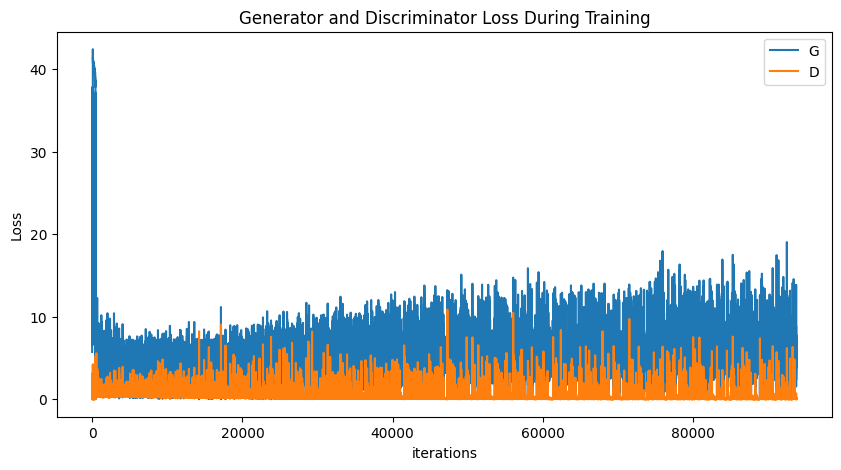

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

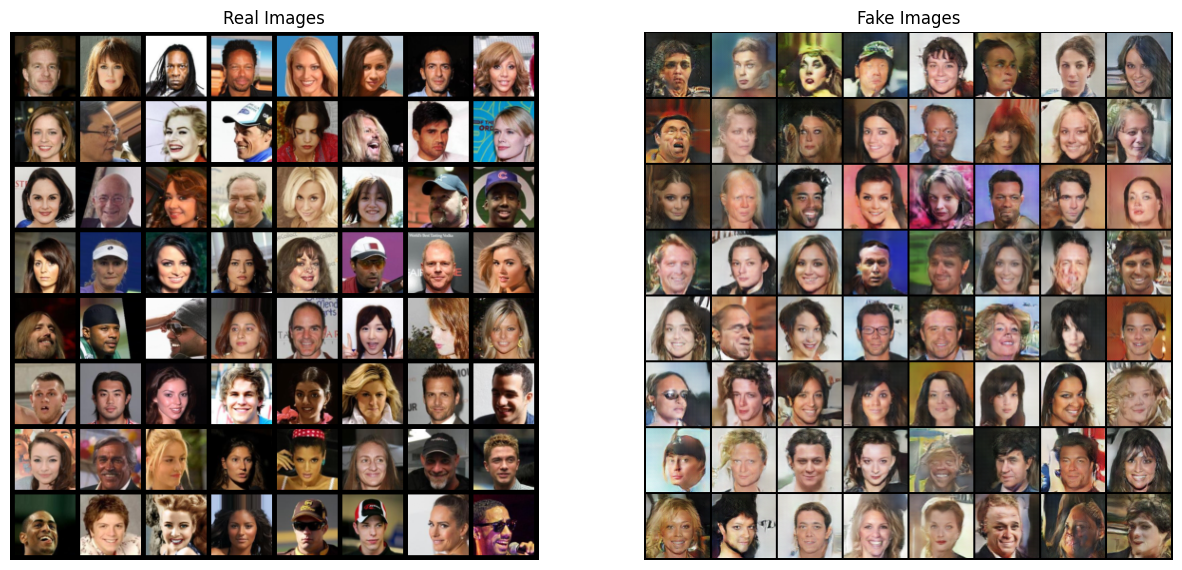

In [40]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[len(img_list)-1],(1,2,0)))
plt.show()